In [54]:
import torch
import torchvision

### Creating Data setup

In [55]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [56]:
NUM_WORKERS = os.cpu_count()

In [57]:
def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names


### creating train step, test step and main train for the model

In [58]:
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

In [59]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [60]:

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [61]:



def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results


In [62]:
train_dir = './dataset/TRAIN/'
test_dir = './dataset/TEST/'

In [63]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [64]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [65]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fc571bb0550>,
 ['Caries', 'Gingivitis'])

In [66]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [67]:
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [68]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [69]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

In [70]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [71]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 2]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [72]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [73]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4393 | train_acc: 0.8296 | test_loss: 0.2771 | test_acc: 0.9279
Epoch: 2 | train_loss: 0.2806 | train_acc: 0.9061 | test_loss: 0.2050 | test_acc: 0.9399
Epoch: 3 | train_loss: 0.2349 | train_acc: 0.9200 | test_loss: 0.1866 | test_acc: 0.9351
Epoch: 4 | train_loss: 0.2160 | train_acc: 0.9195 | test_loss: 0.1896 | test_acc: 0.9351
Epoch: 5 | train_loss: 0.1942 | train_acc: 0.9333 | test_loss: 0.1610 | test_acc: 0.9471
Epoch: 6 | train_loss: 0.1885 | train_acc: 0.9333 | test_loss: 0.1907 | test_acc: 0.9351
Epoch: 7 | train_loss: 0.1635 | train_acc: 0.9446 | test_loss: 0.1632 | test_acc: 0.9447
Epoch: 8 | train_loss: 0.1617 | train_acc: 0.9495 | test_loss: 0.1663 | test_acc: 0.9495
Epoch: 9 | train_loss: 0.1703 | train_acc: 0.9389 | test_loss: 0.1986 | test_acc: 0.9327
Epoch: 10 | train_loss: 0.1579 | train_acc: 0.9479 | test_loss: 0.1384 | test_acc: 0.9495
[INFO] Total training time: 222.290 seconds


In [74]:
from typing import List, Tuple
import torch
from torch import nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import math

def pred_and_plot_images(
    model: nn.Module,
    image_paths: List[str], 
    class_names: List[str],
    image_size: Tuple[int, int] = (224, 224),
    transform: transforms.Compose = None,
    device: torch.device = torch.device("cpu")
):

    # Create a transformation if none is provided
    if transform is None:
        transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])
    
    # Ensure the model is on the target device
    model.to(device)
    model.eval()  # Set the model to evaluation mode

    images = []
    predictions = []
    probabilities = []
    
    with torch.inference_mode():
        for image_path in image_paths:
            # Open and transform the image
            img = Image.open(image_path)
            transformed_image = transform(img).unsqueeze(dim=0)  # Add batch dimension

            # Make prediction
            pred_logits = model(transformed_image.to(device))
            pred_probs = torch.softmax(pred_logits, dim=1)
            pred_label = torch.argmax(pred_probs, dim=1).item()

            # Store results
            images.append(img)
            predictions.append(class_names[pred_label])
            probabilities.append(pred_probs[0, pred_label].item())
    
    # Plot all images in a grid
    num_images = len(image_paths)
    cols = 5  # Number of columns in the grid
    rows = math.ceil(num_images / cols)  # Calculate number of rows
    fig, axs = plt.subplots(rows, cols, figsize=(15, 3 * rows))

    for i, ax in enumerate(axs.flat):
        if i < num_images:
            ax.imshow(images[i])
            ax.set_title(f"Pred: {predictions[i]}\nProb: {probabilities[i]:.3f}")
            ax.axis(False)
        else:
            ax.axis(False)  # Turn off unused subplots

    plt.tight_layout()
    plt.show()


In [75]:
from pathlib import Path

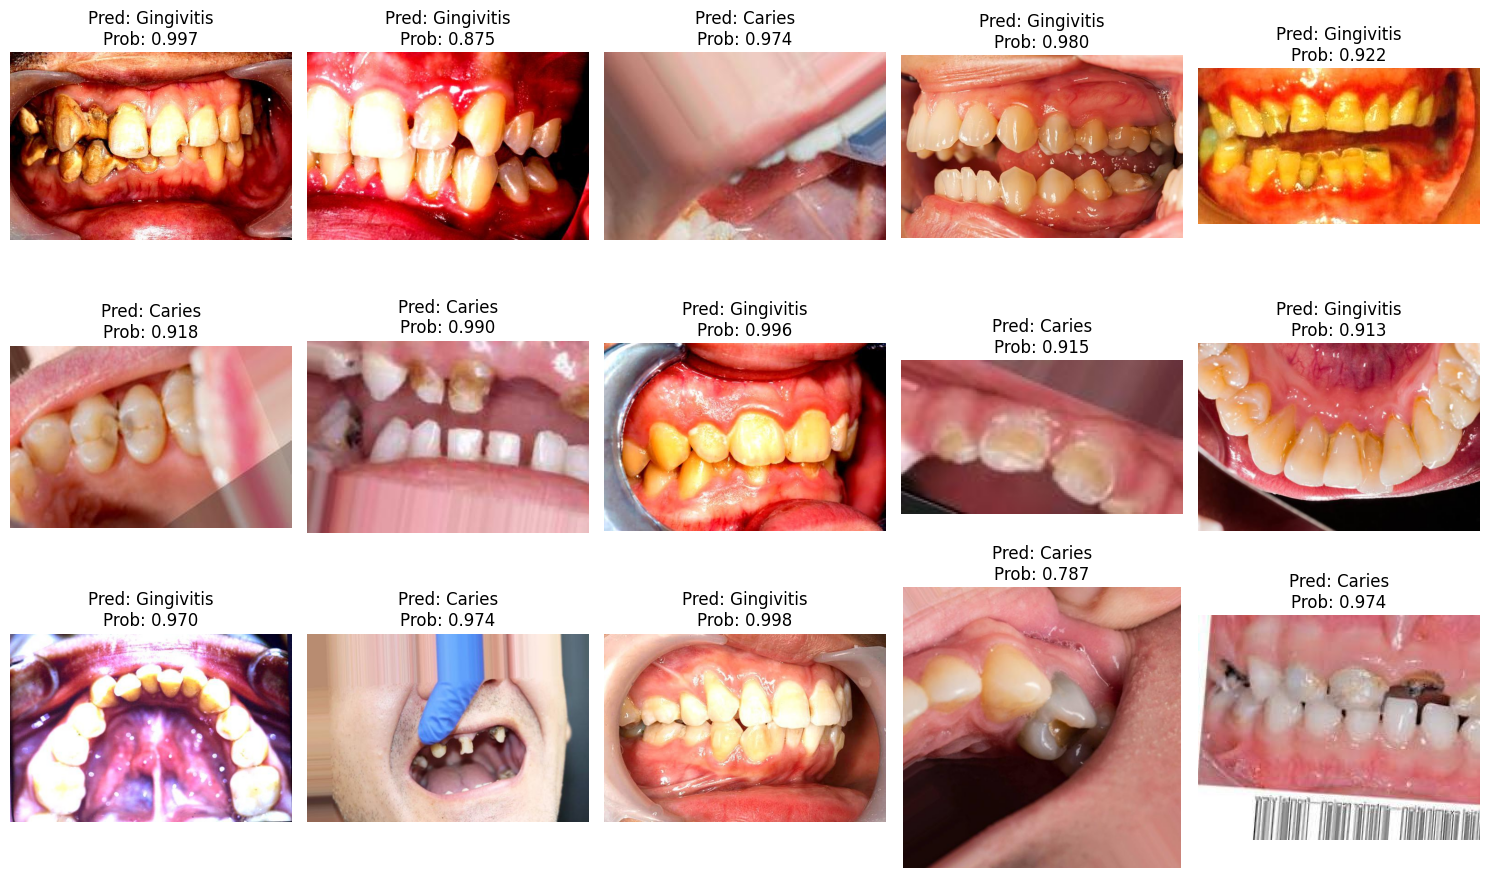

In [76]:
# Get a random list of image paths from the test set
import random
from pathlib import Path

num_images_to_plot = 15
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))  # Get list of all image paths from test data
test_image_path_sample = random.sample(
    population=test_image_path_list,  # Go through all of the test image paths
    k=num_images_to_plot             # Randomly select 'k' image paths to predict and plot
)

# Make predictions on and plot the images together
pred_and_plot_images(
    model=model,
    image_paths=test_image_path_sample,
    class_names=class_names,
    transform=weights.transforms(),
    image_size=(224, 224),
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)


In [77]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def compute_and_plot_confusion_matrix(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    class_names: list,
    device: torch.device = torch.device("cpu")
):
    # Ensure the model is on the target device and in evaluation mode
    model.to(device)
    model.eval()

    # Store true and predicted labels
    all_preds = []
    all_labels = []

    # Turn off gradients for inference
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            # Make predictions
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            # Store predictions and true labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))

    # Plot confusion matrix as a heatmap
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", xticks_rotation="vertical")
    plt.title("Confusion Matrix")
    plt.show()


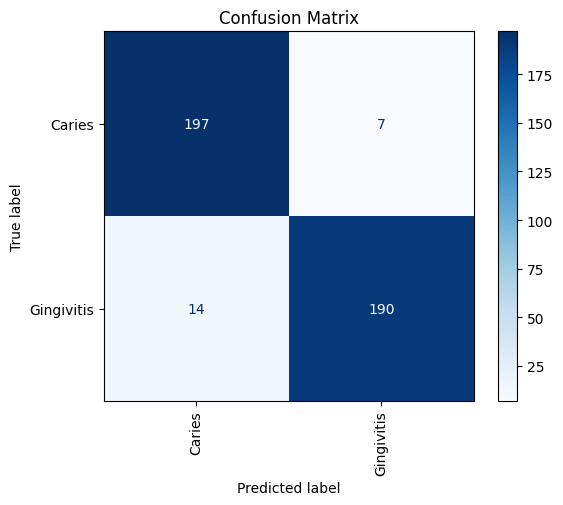

In [78]:
# Compute and plot confusion matrix
compute_and_plot_confusion_matrix(
    model=model,  # Replace with your trained model
    dataloader=test_dataloader,
    class_names=class_names,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)
